## Importing Libraries

In [62]:
import pandas as pd # to handle data
from pycocotools.coco import COCO # wrapper to get data from coco dataset
import numpy as np # library to handle math operations
import matplotlib.pyplot as plt # to visualize data
import math # to make easy math operations

## Fetching Data from COCO Dataset

In [63]:
def get_person_annotations(img_id, coco):
    """
    Get all annotations of Person objects for a given image
    
    Args:
        img_id: COCO dataset image ID
        coco: COCO API instance
    
    Returns:
        Person objects annotations dictionaries list
    """
    person_cat_id = 1 # id of person objects
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id]) 
    annotations = coco.loadAnns(ann_ids)
    
    return annotations

In [64]:
def process_coco_dataset(annotation_file):
    """
    Processes whole COCO dataset and extracts all Person type annotations.
    
    Args:
        annotation_file: COCO annotations file path
        
    Returns:
        Dictionary with img_id as key and annotations list as value
    """
    coco = COCO(annotation_file)
    
    img_ids = coco.getImgIds()
    
    results = {}
    
    for img_id in img_ids:
        person_annotations = get_person_annotations(img_id, coco)
        if person_annotations: 
            results[img_id] = {
                'image_info': coco.loadImgs(img_id)[0],
                'annotations': person_annotations
            }
    
    return results

In [65]:
def extract_person_details(annotations):
    """
    Extracts detailed informations about people from annotations.
    
    Args:
        annotations: annotations dictionary for an image
        
    Returns:
        List of dictionaries with details for each person
    """
    people = []
    img_height = annotations['image_info']['height']
    img_width = annotations['image_info']['width']
    img_url = annotations['image_info']['coco_url']
    for index, ann in enumerate(annotations['annotations']):
        person = {
            'bbox': ann['bbox'],  # [x,y,width,height]
            'area': ann['area'],
            'segmentation': ann['segmentation'],
            'keypoints': ann.get('keypoints', None),
            'num_keypoints': ann.get('num_keypoints', None),
            'iscrowd': ann.get('iscrowd', None),
            'img_height': img_height,
            'img_width': img_width,
            'img_url': img_url
        }
        people.append(person)
    
    return people

For each datum in COCO dataset, extracts details a fills dictionaries with all data regarding people from dataset.

In [66]:
annotation_file = 'person_keypoints_train2017.json' # filepath to annotation file

results = process_coco_dataset(annotation_file) 
number_people = {}
single_person = {}

for img_id, data in results.items():
    people = extract_person_details(data)
    number_people[img_id] = len(people)
    for i, person in enumerate(people, 1):
        single_person[f"{img_id}{i}"] = {'ID': f'{img_id}{i}', 'Img': img_id, 'person_num': i, 'num_people': len(people), 'bbox': person['bbox'], 
                                         'area': person['area'], 'keypoints': person['keypoints'], 'num_keypoints': person['num_keypoints'], 
                                         'is_crowd': person['iscrowd'], 'img_width': person['img_width'], 'img_height': person['img_height'], 'img_url': person['img_url']}

loading annotations into memory...
Done (t=10.05s)
creating index...
index created!


## Building people DataFrame

From dictionaries initialized above creates DataFrame containing, for each row (each person object inside COCO dataset), person_num (ID of the person inside the image), image_id, x and y position of person object rectangle, width and height of rectangle and area of object.

In [67]:
df = pd.DataFrame.from_dict(single_person, orient='index')
df = df.set_index('ID')

In [68]:
df['x'] = df['bbox'].apply(lambda x: x[0])
df['y'] = df['bbox'].apply(lambda x: x[1])
df['width'] = df['bbox'].apply(lambda x: x[2])
df['height'] = df['bbox'].apply(lambda x: x[3])
df = df.drop(['bbox'], axis=1)


Removes all images having, at least, one person with _iscrowd_ attribute set at 1

In [69]:
imgs_to_remove = df[df['is_crowd'] == 1]['Img'].unique()
df = df[~df['Img'].isin(imgs_to_remove)].reset_index(drop=True)

### num_people distribution

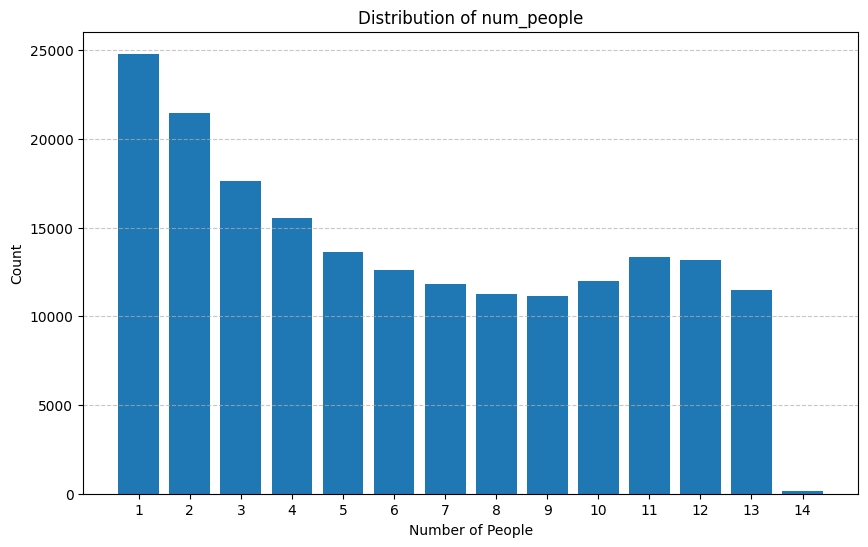

In [70]:
count_data = df['num_people'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(count_data.index, count_data.values)
plt.xlabel('Number of People')
plt.ylabel('Count')
plt.title('Distribution of num_people')
plt.xticks(count_data.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [71]:
# We don't remove the rows having 14 people as they don't represent crowds anymore
# df = df[df['num_people']<14]

We add img_size feature based on width and height of each image

In [72]:
df['img_size'] = df['img_width']*df['img_height']

We add area_norm based on area/img_size

In [73]:
df['area_norm'] = df['area']/df['img_size'] # area normalized to image_size (% of image covered by the object)
# df['area_norm'] = df['width']*df['height']/img_size # area normalized to image_size (% of image covered by the object)

# 1 vs 213 values with area_norm greater than 1 -> we use area as area measure

In [74]:
df[df['area_norm']>1]

,Img,person_num,num_people,area,keypoints,num_keypoints,is_crowd,img_width,img_height,img_url,x,y,width,height,img_size,area_norm
110906,480518,1,1,374686.7411,"[224, 196, 2, 264, 152, 2, 197, 155, 2, 312, 1...",9,0,507,619,http://images.cocodataset.org/train2017/000000...,26.55,19.21,463.9,592.45,313833,1.193905


We remove the only outlier having normalized area > 1

In [75]:
df = df[df['area_norm']<=1]

We compute offset_x and offset_y values as the point in the image where the centre point of the person is located

In [76]:
df['offset_x'] = (df['x']+(df['width']/2))/df['img_width']
df['offset_y'] = (df['y']+(df['height']/2))/df['img_height']

In [77]:
df[df['offset_x']==df['offset_x'].max()]

,Img,person_num,num_people,area,keypoints,num_keypoints,is_crowd,img_width,img_height,img_url,x,y,width,height,img_size,area_norm,offset_x,offset_y
47408,202582,7,10,7.35835,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,640,480,http://images.cocodataset.org/train2017/000000...,638.34,207.71,1.66,7.35,307200,0.000024,0.998703,0.440385


In [78]:
df[df['offset_x']==df['offset_x'].min()]

,Img,person_num,num_people,area,keypoints,num_keypoints,is_crowd,img_width,img_height,img_url,x,y,width,height,img_size,area_norm,offset_x,offset_y
86009,458309,11,11,12.71815,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,612,612,http://images.cocodataset.org/train2017/000000...,0.09,53.32,1.89,9.99,374544,0.000034,0.001691,0.095286



We can see that values are in range 0-1, while values should be in range 0-0.5

In [79]:
# TODO
# Change offset values as ranges are not good

In [80]:
df['offset'] = (np.sqrt(df['offset_x']**2 + df['offset_y']**2) / math.sqrt(2))*2

We list all keypoints labels in the dataset for each keypoint in person image

In [81]:
face = ["nose_v", "left_eye_v", "right_eye_v", "left_ear_v", "right_ear_v"] # face related keypoints visibilities
body = ["left_shoulder_v", "right_shoulder_v", "left_hip_v", "right_hip_v"] # body related keypoints visibilities
extremities = ["left_elbow_v", "right_elbow_v", "left_wrist_v", "right_wrist_v", "left_knee_v", "right_knee_v", "left_ankle_v", "right_ankle_v"] # extremities related keypoints visibilities

We create, for each keypoint, a feature in the dataset with its corresponding value, scaled in the 0-1 range

In [82]:
for index, body_part in enumerate(face + body + extremities):
    df[f"{body_part}"] = df['keypoints'].apply(lambda x: (x[index * 3+2])/2) # in order to rescale it on 0-1 range

We compute ratios by calculating face, body and extremities means

In [83]:
df['vis_face_ratio'] = df[face].mean(axis=1)
df['vis_body_ratio'] = df[body].mean(axis=1)
df['vis_extremities_ratio'] = df[extremities].mean(axis=1)

In [84]:
df.to_csv('person_anns.csv', index=False)

## Creating difficulty measures formulas

#### num_people_diff

In [85]:
def num_people_diff(num_people: int):
    return 1-(1/(num_people+1))

In [86]:
def add_num_people_diff(df):
    df['num_people_diff'] = df['num_people'].apply(num_people_diff)
    return df

#### people_size_diff

In [87]:
def add_people_size_diff(df):
    df['people_size_diff'] = 1-df['area_norm']
    df = df.drop(['area_norm'], axis=1)
    return df

#### visibility_diff

In [88]:
def compute_visibility_diff(df):
    df = df.rename(columns={'vis_face_ratio': 'face_avg_ratio', 'vis_body_ratio': 'body_avg_ratio', 'vis_extremities_ratio': 'extremities_avg_ratio'})
    df['visibility_diff'] = 1-(df['face_avg_ratio']*0.5+df['body_avg_ratio']*0.3+df['extremities_avg_ratio']*0.2) 
    return df

#### offset_diff

In [89]:
def add_offset_diff(df):
    df['offset_diff'] = 1-df['offset']
    return df

#### total_dif

In [90]:
def add_total_dif(df):
    df['total_dif'] = (df['num_people_diff']+df['people_size_diff']+df['visibility_diff']+df['offset_diff'])/4
    return df

## Creating Grouped DataFrames

#### Creates functions in order to build grouped dataframes, based on different parameters (top 75, side 25)

In [91]:
def create_df(col_name, col_dimension_name, param_num):
    return df[(df[col_name])<=(param_num*df[f'img_{col_dimension_name}'])] # All people whose starting top left keypoint are inside parameters given are counted in the df
    # return df[(df[col_name]+df[col_dimension_name])<=(param_num*dimension)] # People whose all figure is inside parameters are counted

In [92]:
def create_grouped_df(df):
    return df[['Img', 'num_people', 'area_norm', 'offset', 'vis_face_ratio', 'vis_body_ratio', 'vis_extremities_ratio']].groupby('Img').agg({
    'num_people': 'count',
    'area_norm': 'mean', 
    'offset': 'mean',
    'vis_face_ratio': 'mean',
    'vis_body_ratio': 'mean',
    'vis_extremities_ratio': 'mean',
})

#### all images

In [93]:
all_img_df = create_grouped_df(df)

#### top 75

In [94]:
top_75_df = create_grouped_df(create_df('y', 'height', 0.75))

#### top 25

In [95]:
top_25_df = create_grouped_df(create_df('y', 'height', 0.25))

#### top 50

In [96]:
top_50_df = create_grouped_df(create_df('y', 'height', 0.5))

#### side 25

In [97]:
side_25_df = create_grouped_df(create_df('x', 'width', 0.25))

#### side 50

In [98]:
side_50_df = create_grouped_df(create_df('x', 'width', 0.5))

#### side 75

In [99]:
side_75_df = create_grouped_df(create_df('x', 'width', 0.75))

#### Creates a list with all datasets considered

In [100]:
df_list = [all_img_df, top_25_df, top_50_df, top_75_df, side_25_df, side_50_df, side_75_df]
df_names = ['All', 'Top 25', 'Top 50', 'Top 75', 'Side 25', 'Side 50', 'Side 75']

## Adding visibility metrics to data

In [101]:
for i, (dframe, dname) in enumerate(zip(df_list, df_names)):
    df_list[i] = add_num_people_diff(dframe)
    df_list[i] = add_people_size_diff(df_list[i])
    df_list[i] = compute_visibility_diff(df_list[i])
    df_list[i] = add_offset_diff(df_list[i])
    df_list[i] = add_total_dif(df_list[i])

In [102]:
df_list[0].head()

,num_people,offset,face_avg_ratio,body_avg_ratio,extremities_avg_ratio,num_people_diff,people_size_diff,visibility_diff,offset_diff,total_dif
Img,,,,,,,,,,
36,1,1.290327,1.000000,1.000000,0.5000,0.500000,0.720162,0.100000,-0.290327,0.257459
49,6,1.266714,0.233333,0.291667,0.1875,0.857143,0.996770,0.758333,-0.266714,0.586383
61,3,0.981819,0.000000,0.000000,0.0000,0.750000,0.997873,1.000000,0.018181,0.691514
74,6,0.858286,0.000000,0.000000,0.0000,0.857143,0.998416,1.000000,0.141714,0.749318
77,5,0.956713,0.200000,0.550000,0.5750,0.833333,0.983026,0.620000,0.043287,0.619912


## Plotting

In [103]:
def plot_hist(df, title):
    plt.bar(df['num_people_diff'].value_counts().keys(), df['num_people_diff'].value_counts().values, width=0.005, color="skyblue", edgecolor="black")
    plt.xlabel("num_people_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

### num_people_diff

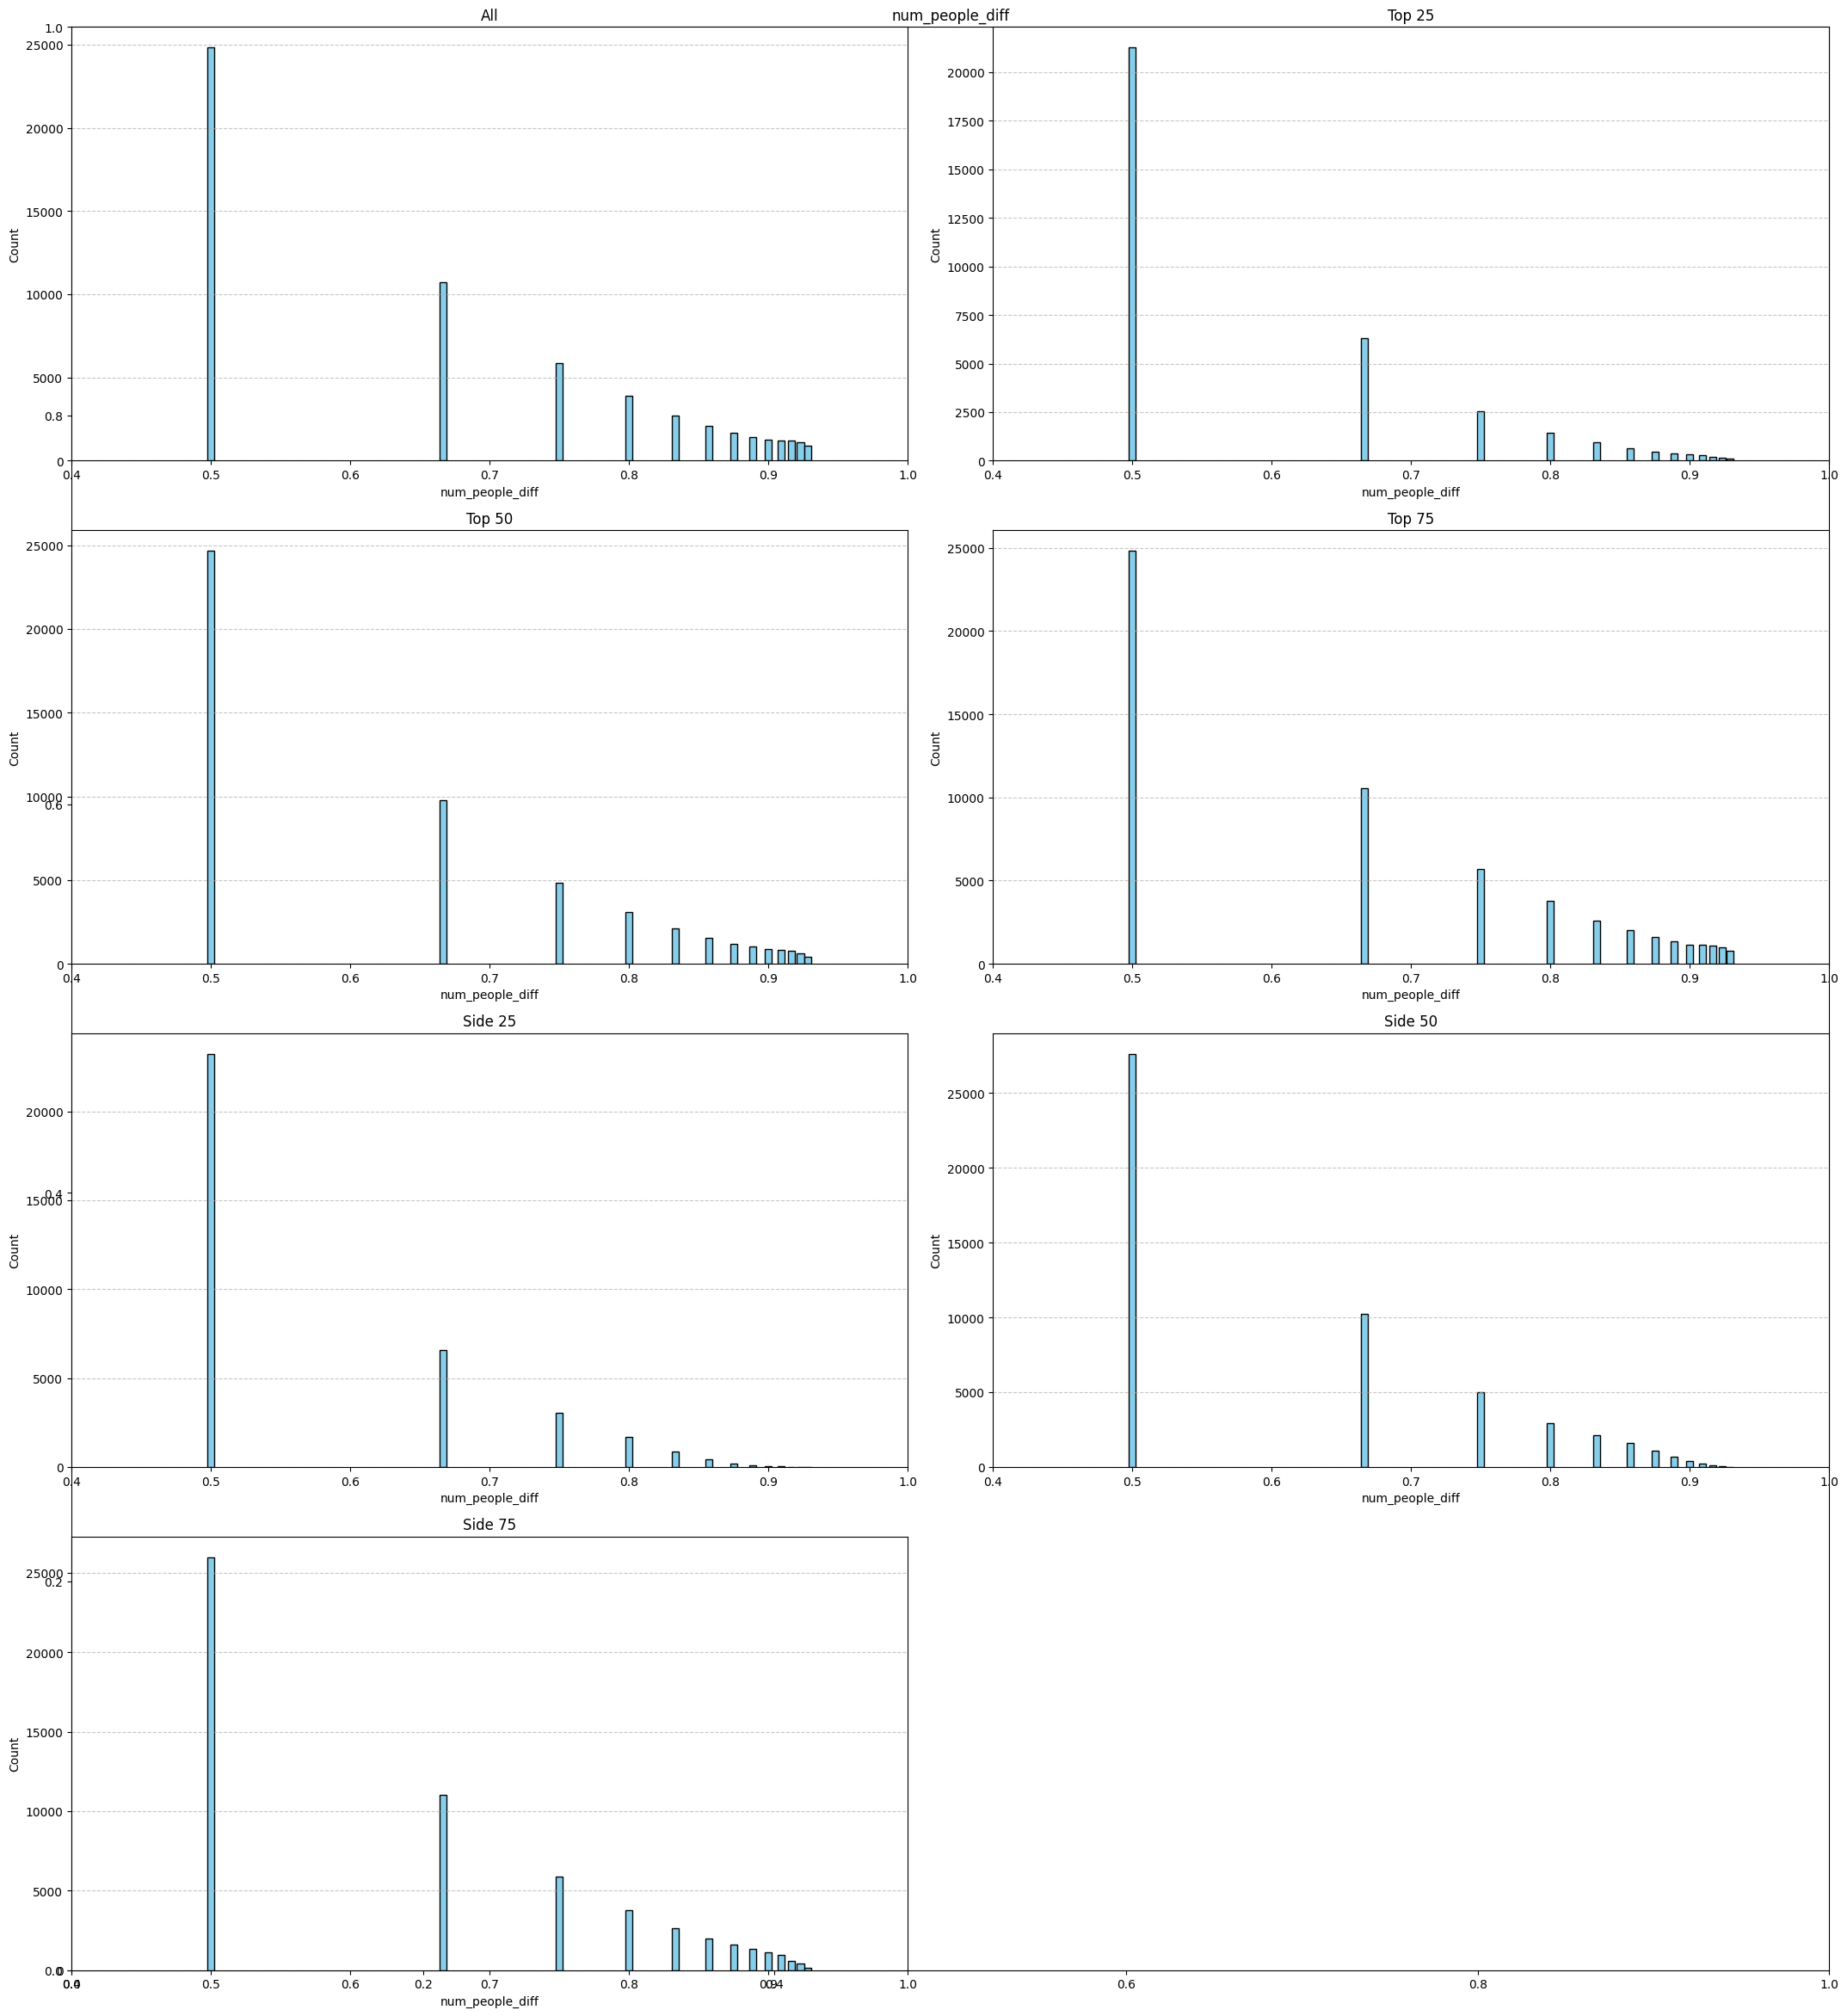

In [104]:
plt.figure(figsize=(22, 24))
plt.title(f"num_people_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_hist(data[0], data[1])
    ax.set_xlim(0.4, 1)
plt.tight_layout()

plt.show()

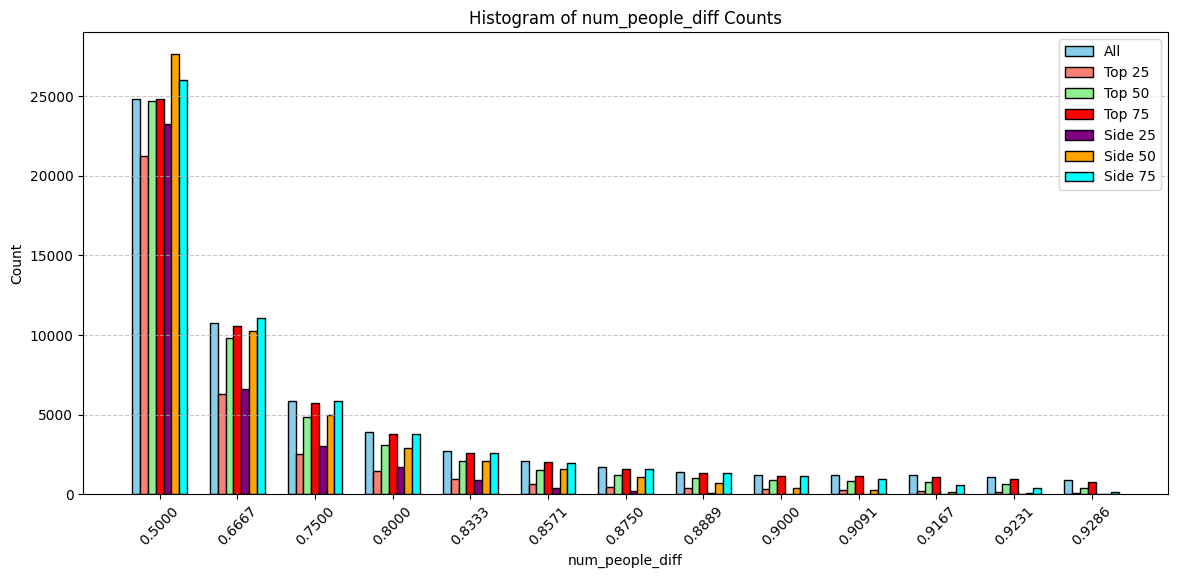

In [105]:
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]

unique_keys = sorted(set().union(*(df_temp['num_people_diff'].unique() for df_temp in df_list)))
rounded_unique_keys = [f"{key:.4f}" for key in unique_keys]

bar_width = 0.1
x_positions = np.arange(len(unique_keys)) 

plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    counts = df_temp['num_people_diff'].value_counts()
    values = [counts.get(key, 0) for key in unique_keys]
    
    offset = (i - (len(df_list) - 1) / 2) * bar_width
    plt.bar(x_positions + offset, values, width=bar_width, color=color, edgecolor="black", label=f"DataFrame {i+1}")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of num_people_diff Counts")
plt.xticks(x_positions, rounded_unique_keys, rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()


### people_size_dif

In [106]:
def plot_people_size_diff(df, title):
    plt.hist(df['people_size_diff'], bins=100, color="skyblue", edgecolor="black", alpha=0.7, density=False)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

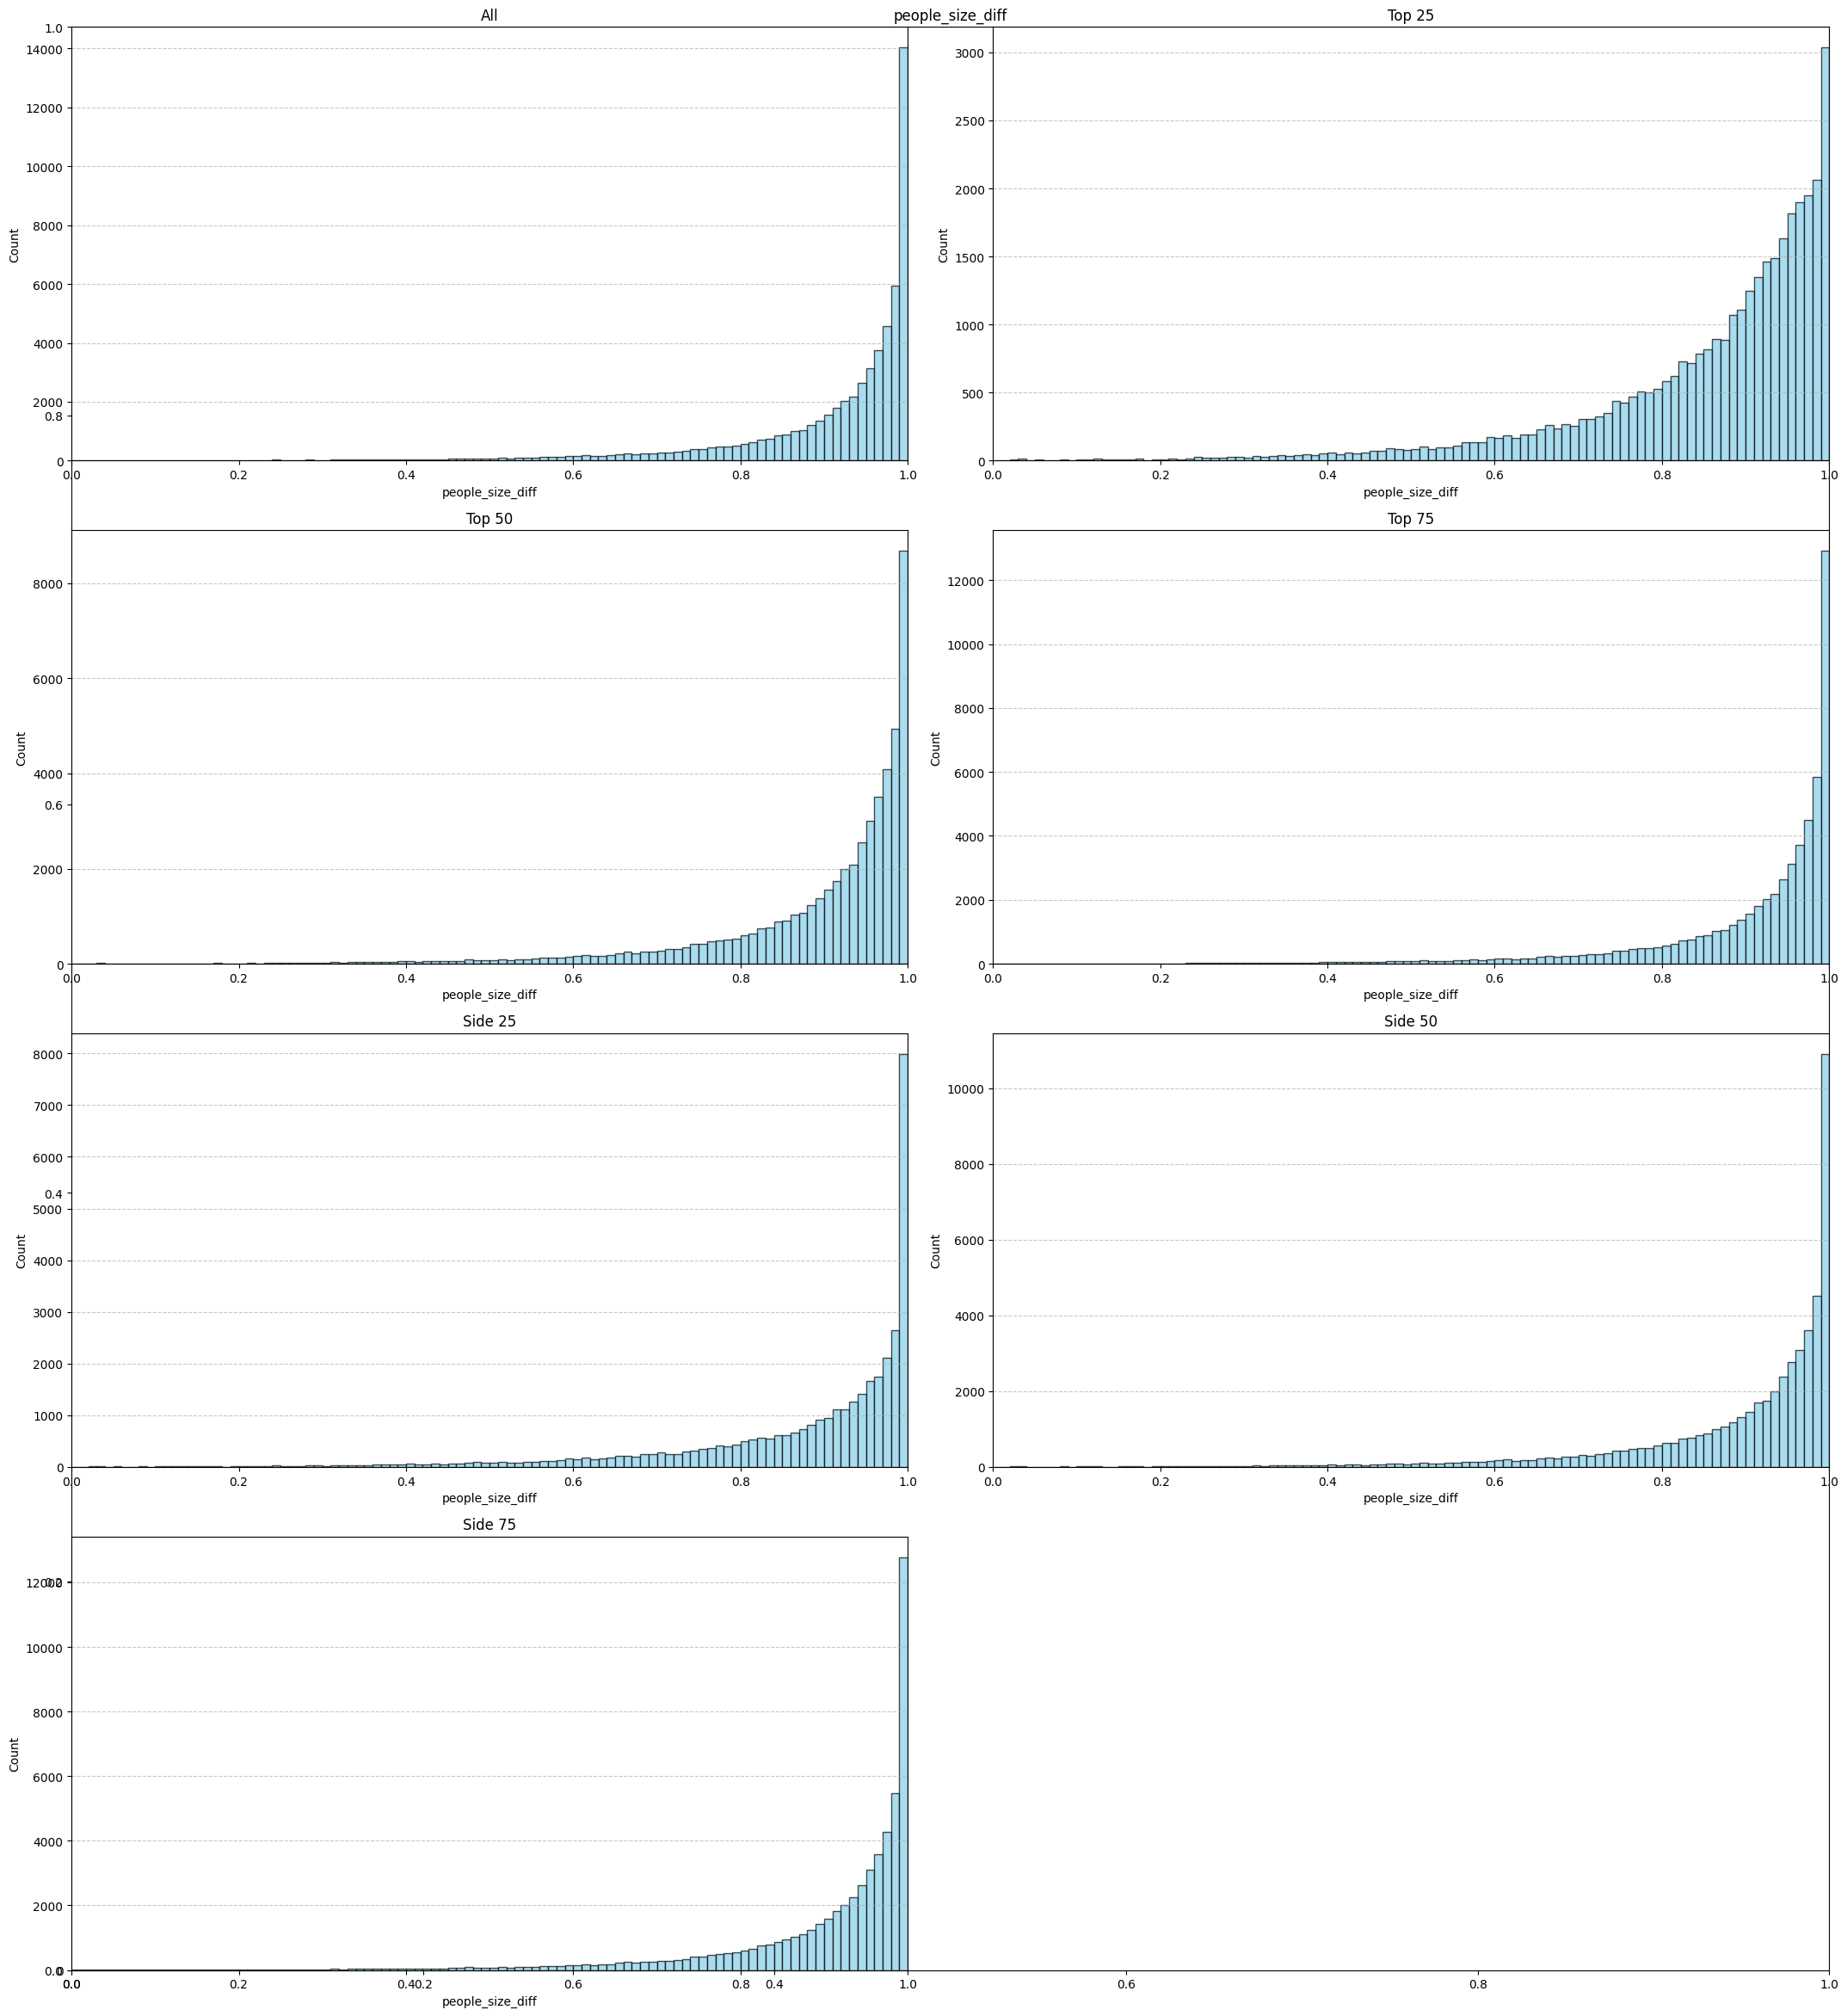

In [107]:
plt.figure(figsize=(22, 24))
plt.title(f"people_size_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_people_size_diff(data[0], data[1])
    ax.set_xlim(0, 1)
plt.tight_layout()

plt.show()

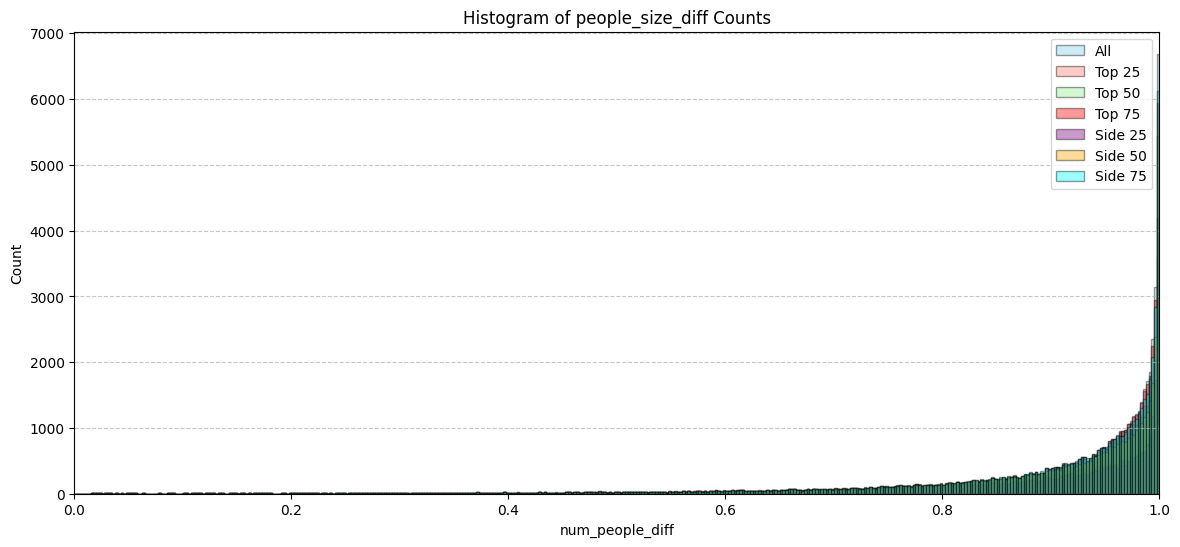

In [108]:
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]


plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['people_size_diff'], bins=400, color=color, edgecolor="black", alpha=0.4, density=False)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of people_size_diff Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0,1)
plt.legend(df_names)
plt.show()


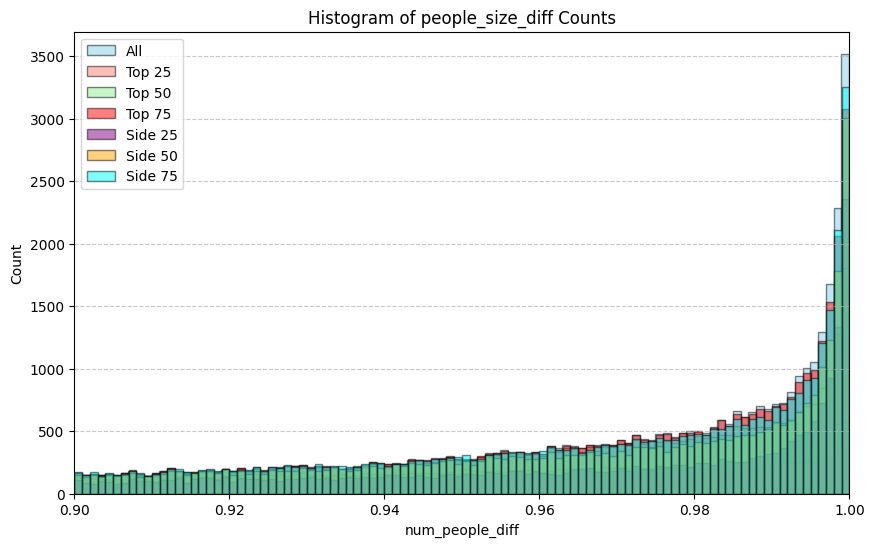

In [109]:
plt.figure(figsize=(10, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['people_size_diff'], bins=1000, color=color, edgecolor="black", alpha=0.5, density=False)
    plt.xlabel("people_size_diff")
    plt.ylabel("Count")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of people_size_diff Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0.9,1)
plt.legend(df_names)
plt.show()


### visibility_diff

In [110]:
def plot_visibility_diff(df, title):
    plt.hist(df['visibility_diff'], bins=100, color="skyblue", edgecolor="black", alpha=0.7, density=False)
    plt.xlabel("visibility_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

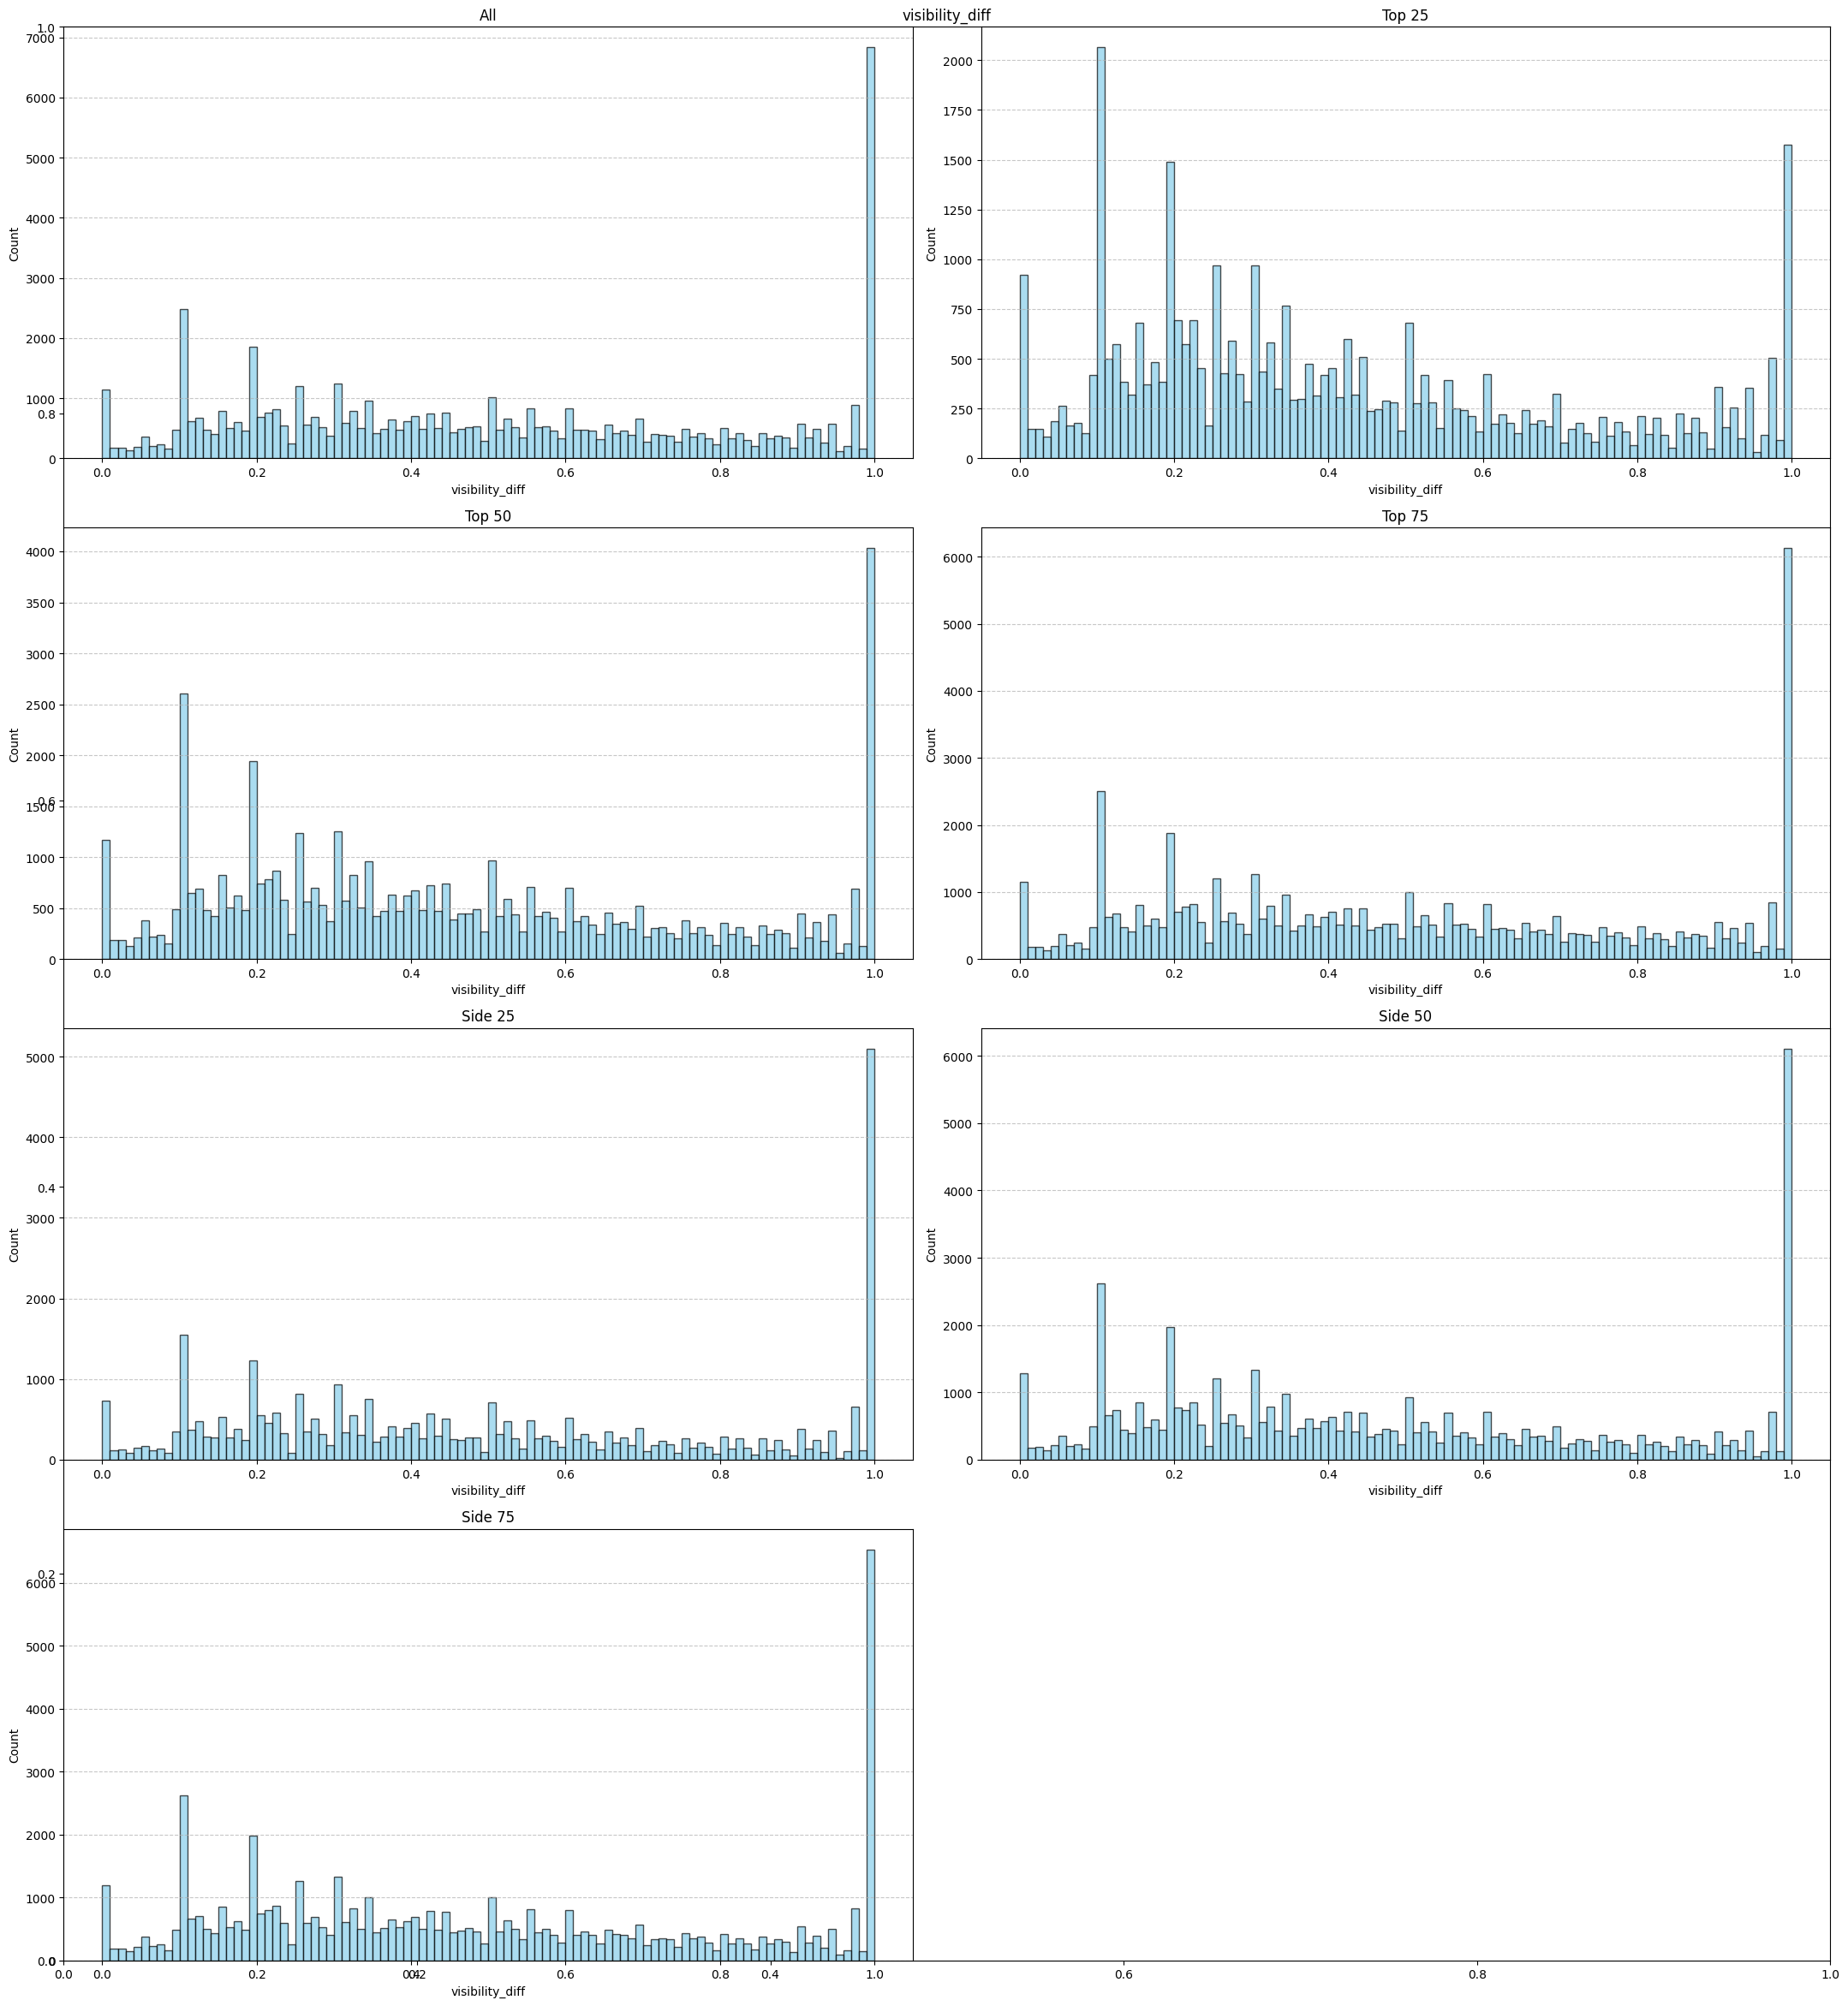

In [111]:
plt.figure(figsize=(22, 24))
plt.title(f"visibility_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_visibility_diff(data[0], data[1])
plt.tight_layout()

plt.show()

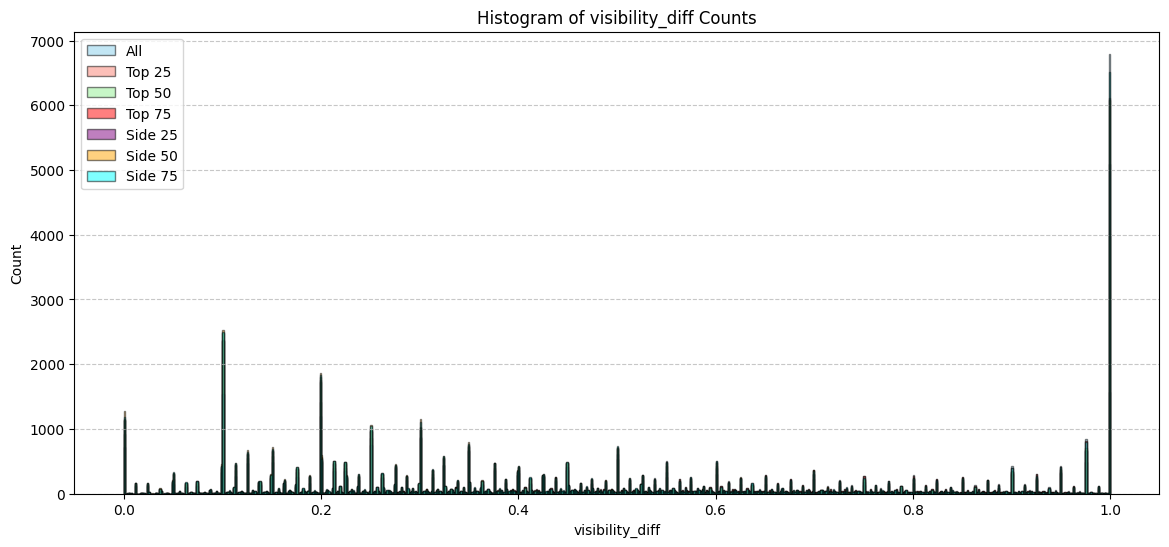

In [112]:
plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['visibility_diff'], bins=800, color=color, edgecolor="black", alpha=0.5, density=False)
    plt.xlabel("visibility_diff")
    plt.ylabel("Count")

plt.xlabel("visibility_diff")
plt.ylabel("Count")
plt.title("Histogram of visibility_diff Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()


### offset_diff

In [113]:
def plot_offset_diff(df, title):
    plt.hist(df['offset_diff'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=False)
    plt.xlabel("offset_diff")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

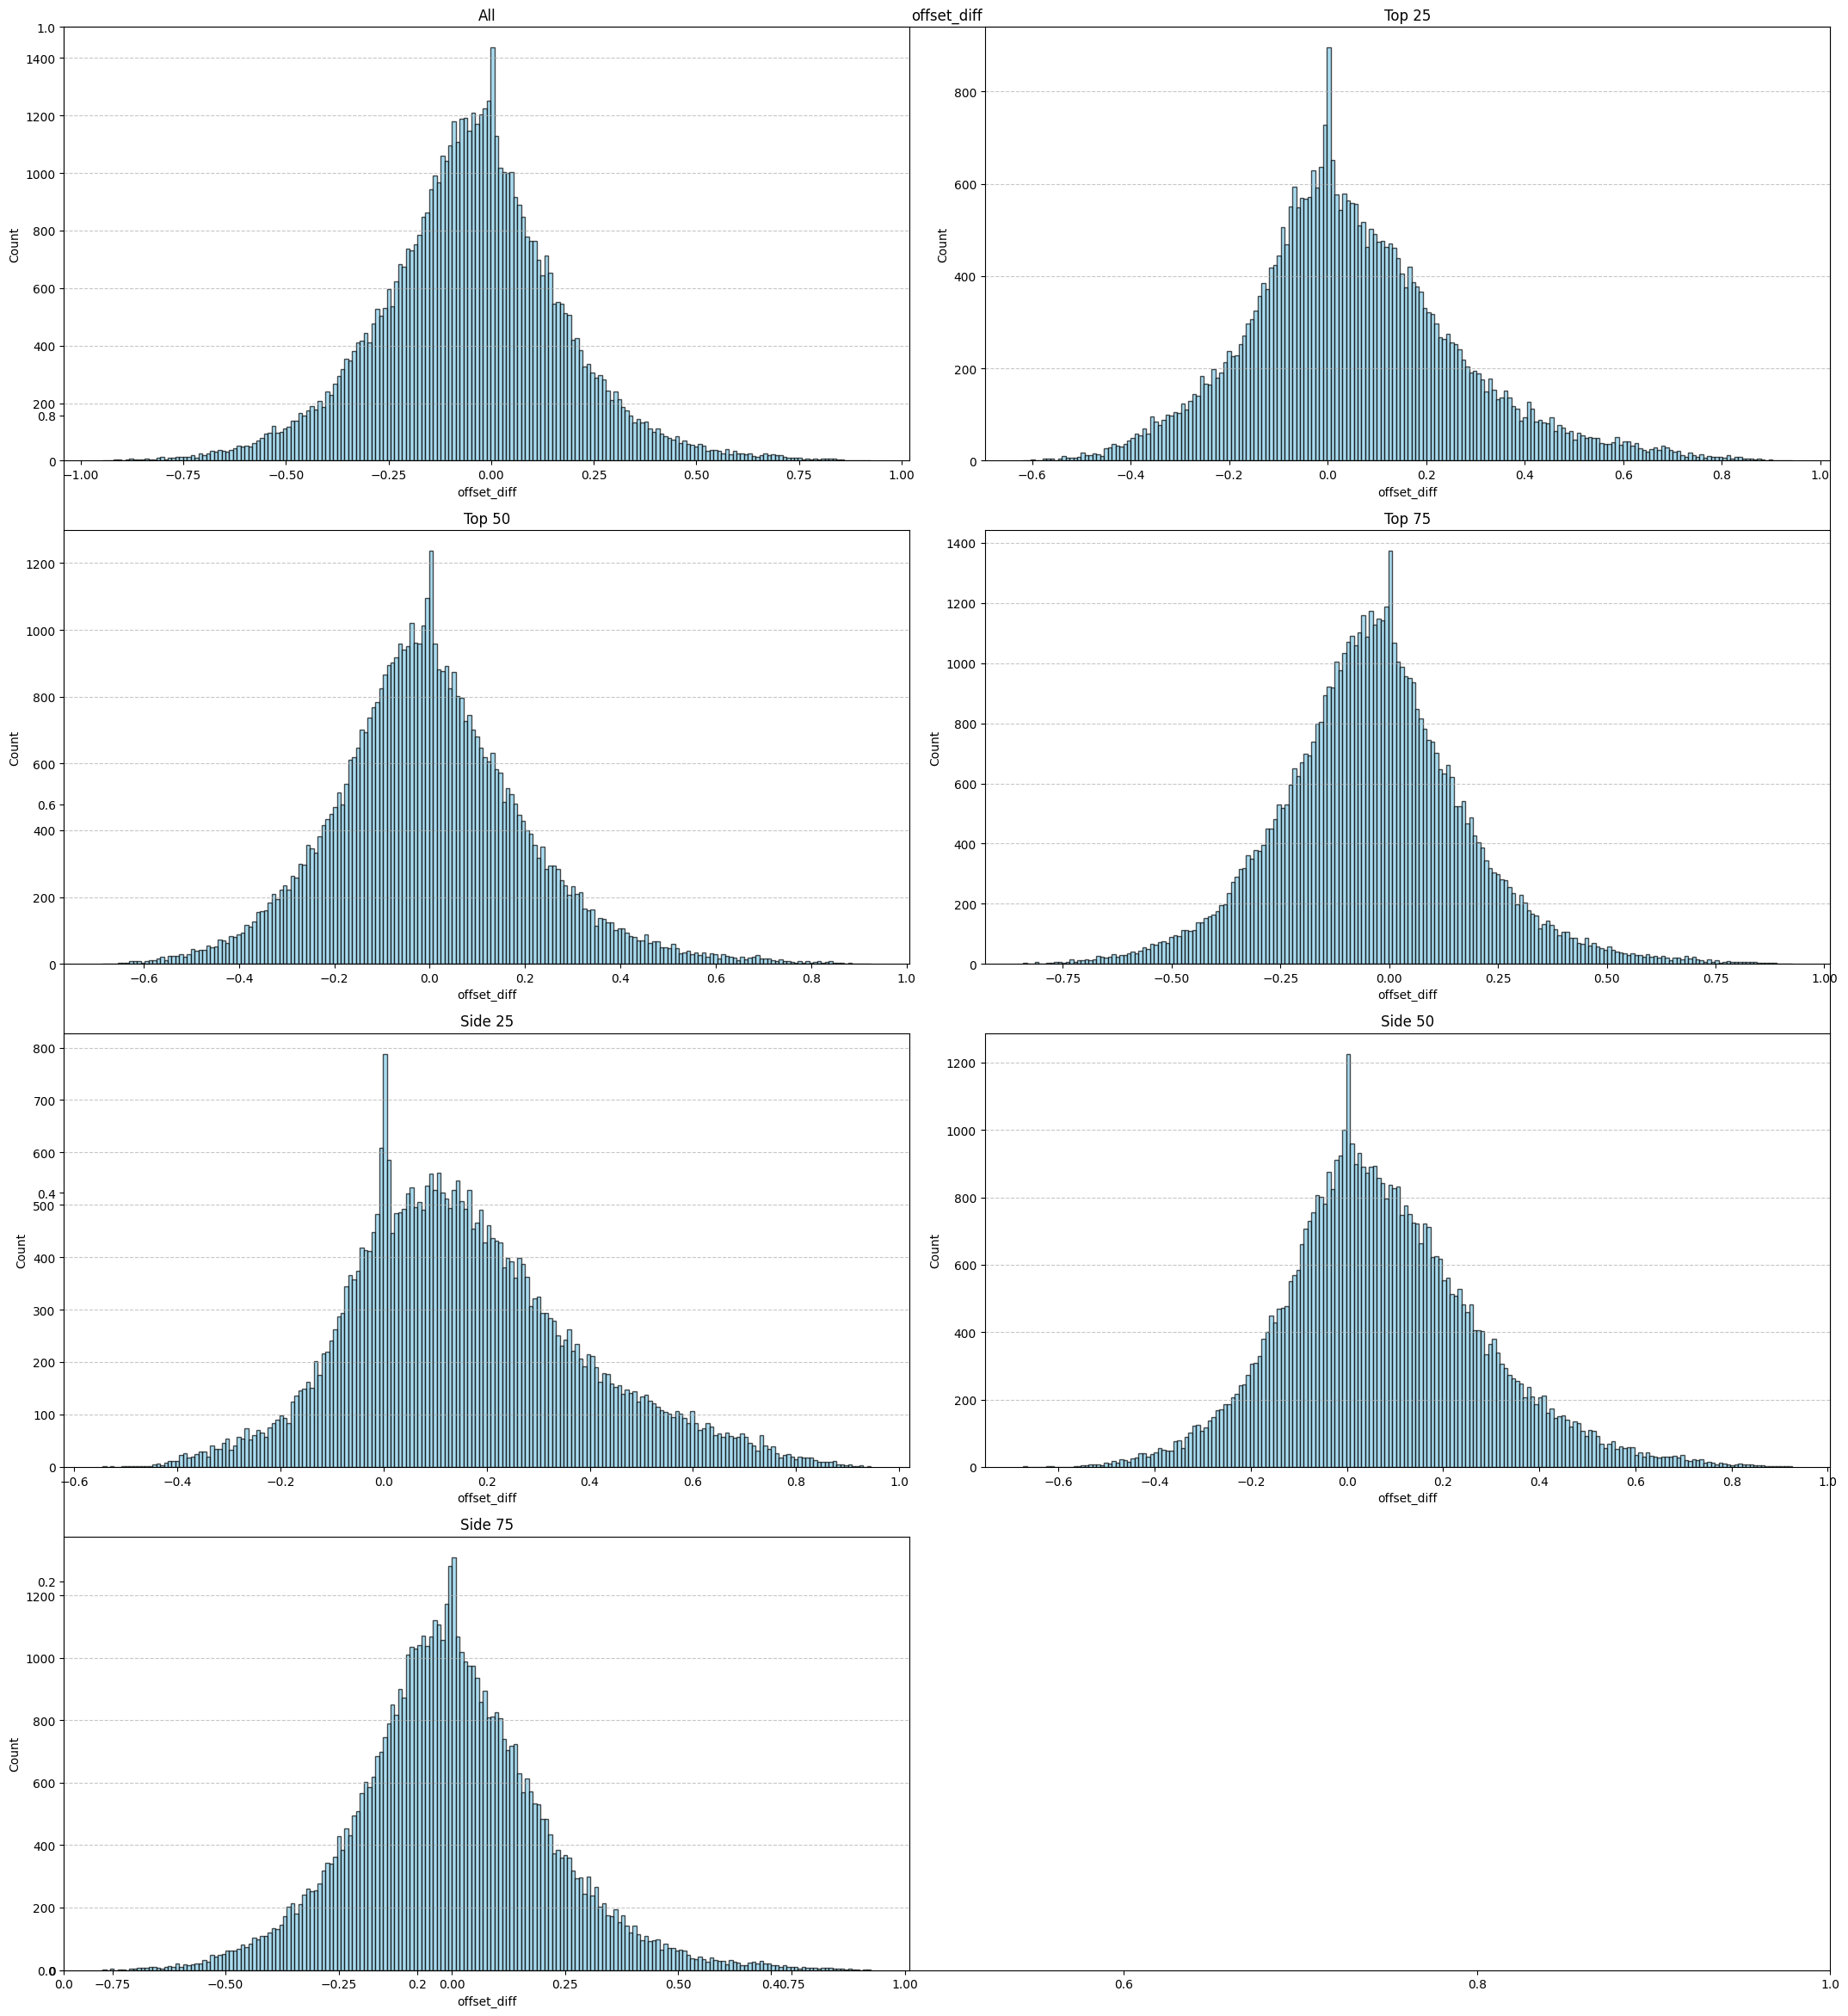

In [114]:
plt.figure(figsize=(22, 24))
plt.title(f"offset_diff")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_offset_diff(data[0], data[1])
plt.tight_layout()

plt.show()

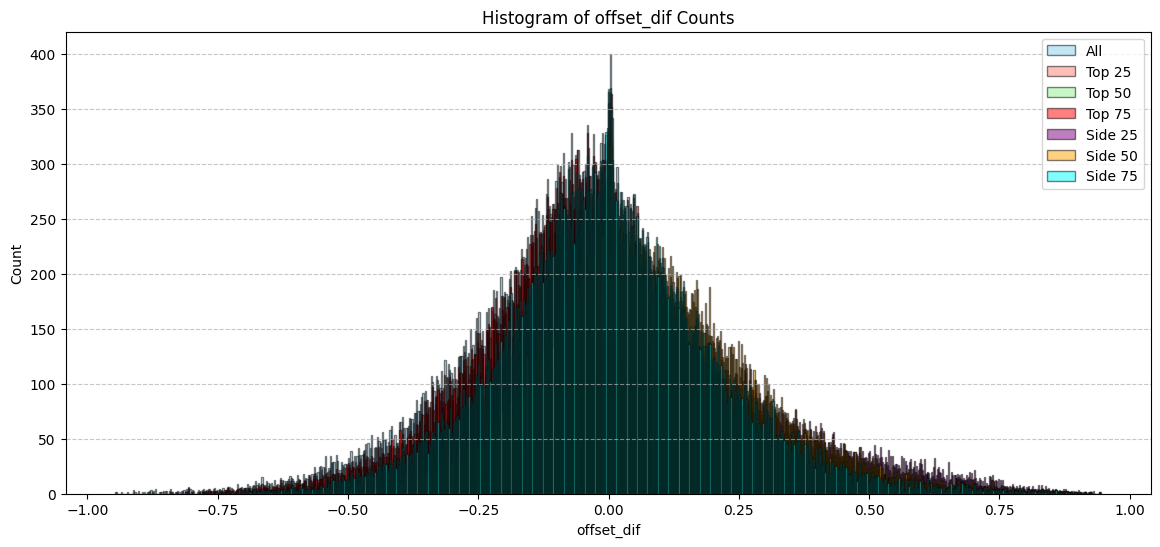

In [115]:
plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['offset_diff'], bins=800, color=color, edgecolor="black", alpha=0.5, density=False)
    plt.xlabel("offset_diff")
    plt.ylabel("Count")

plt.xlabel("offset_dif")
plt.ylabel("Count")
plt.title("Histogram of offset_dif Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()


### total_dif

In [116]:
def plot_total_dif(df, title):
    plt.hist(df['total_dif'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=False)
    plt.xlabel("total_dif")
    plt.ylabel("Count")
    plt.title(f"{title}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

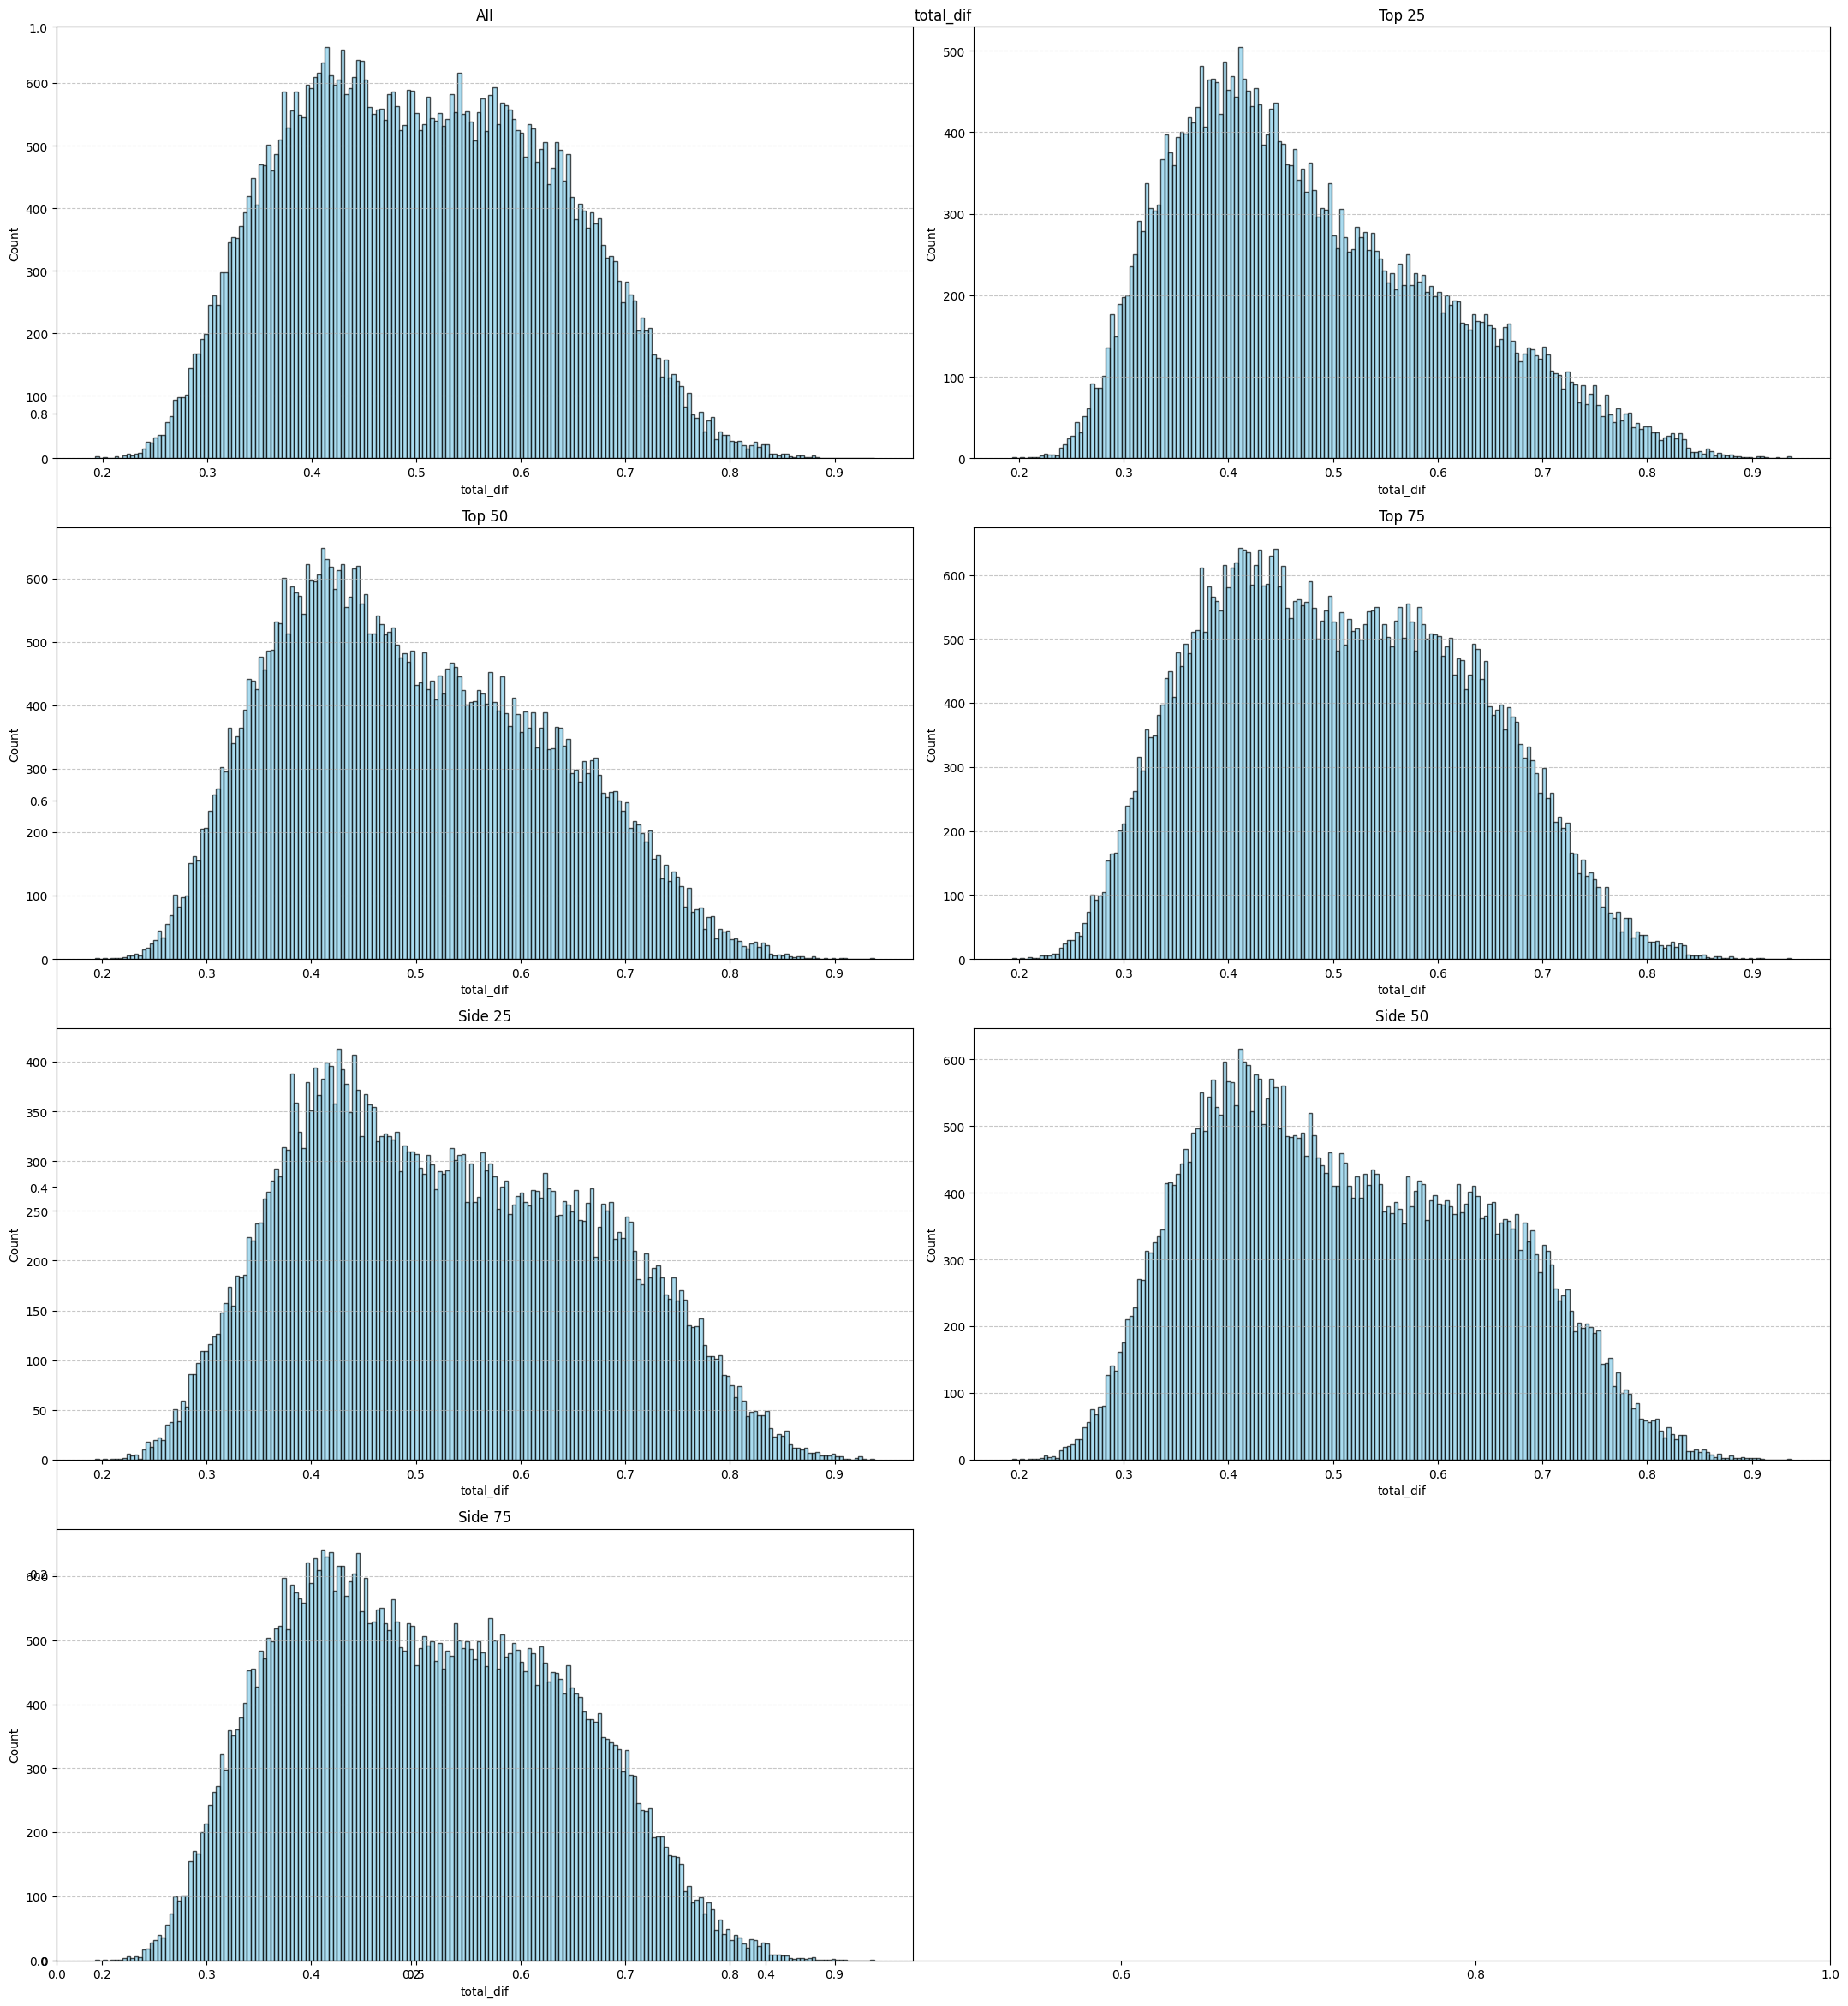

In [117]:
plt.figure(figsize=(22, 24))
plt.title(f"total_dif")
for index, data in enumerate(zip(df_list, df_names)):
    ax = plt.subplot(4, 2, index+1)
    plot_total_dif(data[0], data[1])
plt.tight_layout()

plt.show()

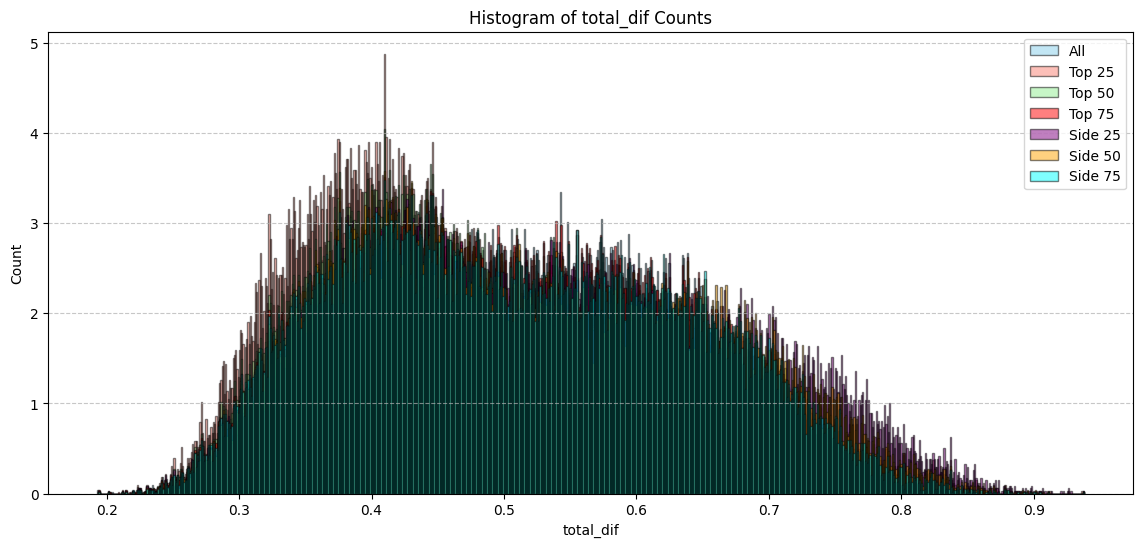

In [118]:
plt.figure(figsize=(14, 6))

for i, (df_temp, color) in enumerate(zip(df_list, colors)):
    plt.hist(df_temp['total_dif'], bins=800, color=color, edgecolor="black", alpha=0.5, density=True)
    plt.xlabel("total_dif")
    plt.ylabel("Count")

plt.xlabel("total_dif")
plt.ylabel("Count")
plt.title("Histogram of total_dif Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(df_names)
plt.show()
